Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50000 10000


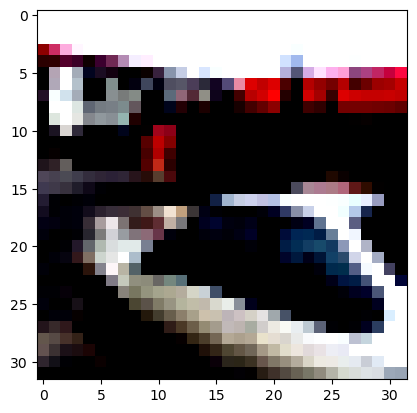

In [23]:
# Download CIFAR 10 dataset for training and validation purposes and apply the following changes on each image:
# 1) make it a tensor
# 2) normalize it based on the mean and standard deviation among all pixels in each channel (RGB).
# Print the size of training and validation datasets
# Plot the last training image

from torchvision import datasets
from torchvision import transforms
from matplotlib import pyplot as plt
import torch

# default dataset needed for normalization:
dataset_train = datasets.CIFAR10('.', train=True, download=True, transform=transforms.ToTensor())

# calculation values for normalization:
imgs = torch.stack([img for (img, label) in dataset_train], dim = 3)
mean_deviation = imgs.view(3, -1).mean(dim=1)
standard_deviation = imgs.view(3, -1).std(dim=1)

# normalized datasets:
dataset_train_trans = datasets.CIFAR10('.', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_deviation.numpy(), standard_deviation.numpy())
]))
dataset_val_trans = datasets.CIFAR10('.', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_deviation.numpy(), standard_deviation.numpy())
]))

# print lengths and plot the last training image:
len_dataset_train_trans = len(dataset_train_trans)
len_dataset_val_trans = len(dataset_val_trans)

print(len_dataset_train_trans, len_dataset_val_trans)
img, label = dataset_train_trans.__getitem__(len_dataset_train_trans - 1)
plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15000 3000


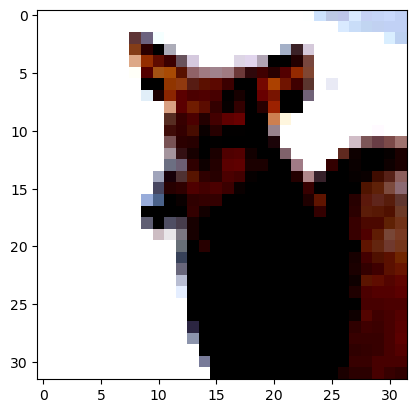

In [24]:
# We want to make a tertiary classifier that distinguishes between deers, dogs, and horses, labeled as 4, 5, and 7, resp.
# Create the subset training and validation datasets for this purpose.
# Print the size of these datasets.
# Plot the last training image

label_map = {4:0, 5:1, 7:2}
class_names = ["deers", "dogs", "horses"]

dataset_train_filtered  =   [(img, label_map[label]) for img, label in dataset_train_trans if label in [4,5,7]]
dataset_val_filtered    =   [(img, label_map[label]) for img, label in dataset_val_trans if label in [4,5,7]]

# print lengths and plot the last training image:
len_dataset_train = len(dataset_train_filtered)
len_dataset_val = len(dataset_val_filtered)

print(len_dataset_train, len_dataset_val)
img, label = dataset_train_filtered.__getitem__(len_dataset_train - 1)
plt.imshow(img.permute(1,2,0))


In [47]:
# Create a NN consisting of 
# 1) a linear layer that receives appropriate number of input features and outputs 1024 features, followed by hyperbolic
#    tangent as the activation function,
# 2) a linear layer that receives appropriate number of input features and outputs 256 features, followed by hyperbolic
#    tangent as the activation function,
# 3) the final linear layer with appropriate input and output number of features, followed by logarithm of softmax
# Print total number of exisiting parameters in the NN with respect to which gradient of loss must be computed.

import torch.nn as nn

n_classes = 3

model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 256),
    nn.Tanh(),
    nn.Linear(256, n_classes),
    nn.LogSoftmax(dim=1)
)

print(sum([param.numel() for param in model.parameters() if param.requires_grad==True]))


3409923


In [48]:
# Our training functionality is supposed to compute gradient on batches of training data, randlomy selected each time.
# To this end, create a training data loader with batch size 32 that randomizes access to each batch.
# Also, create a validation data loader with the same batch size that does not randomize access to each batch (no need!)
# Print the number of batches in training and validation data loaders
# Print the size of the last batch in each of the training and validation loaders (they are not necessarily 32)

train_loader    = torch.utils.data.DataLoader(dataset_train_filtered, batch_size=32, shuffle=True)
val_loader      = torch.utils.data.DataLoader(dataset_val_filtered, batch_size=32, shuffle=False)

len_train_loader        = len(train_loader)
len_val_loader          = len(val_loader)
last_train_batch_size   = len([(imgs, labels) for imgs, labels in train_loader][len_train_loader - 1][0])
last_val_batch_size     = len([(imgs, labels) for imgs, labels in val_loader][len_val_loader - 1][0])

print(len_train_loader, len_val_loader)
print(last_train_batch_size, last_val_batch_size)

469 94
24 24


In [49]:
# Define your training function that receives the data loaders, model, loss function, optimizer, and number of epochs.
# In each epoch, you should go through each training data batch, and:
# 1) compute the output batch, and accordingly the loss
# 2) compute the gradient of loss wrt parameters, and update the parameters
# After covering all epochs, your training function must report
# 1) the training accuracy, and
# 2) the validation accuracy

def training_loop(n_epochs, loss_fn, model, optimizer, train_loader, val_loader):
    for epoch in range(1, 1 + n_epochs):
        for imgs, labels in train_loader:
            batch_size = imgs.shape[0]
            outs = model(imgs.view(batch_size, -1)) # outs : batch_size * n_calsses
            loss = loss_fn(outs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print("epoch=%d loss=%f" %(epoch, loss)) # loss of last batch
    
    total = 0
    correct = 0
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outs = model(imgs.view(batch_size, -1)) # outs : batch_size * n_calsses
        max_vals, max_classes = outs.max(dim=1) # max_vals : batch_size, max_classes : batch_size
        total += batch_size
        correct += (max_classes == labels).sum() # number of correct pred in a single batch
    print("training accuracy    =%f" %(correct/total))

    total = 0
    correct = 0
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outs = model(imgs.view(batch_size, -1)) # outs : batch_size * n_calsses
        max_vals, max_classes = outs.max(dim=1) # max_vals : batch_size, max_classes : batch_size
        total += batch_size
        correct += (max_classes == labels).sum() # number of correct pred in a single batch
    print("validation accuracy  =%f" %(correct/total))

In [51]:
# Call the training function on the created data loaders, the created NN, negative log likelihood loss function, 
# stochastic gradient descent optimizer, and 100 epochs.
# Is the model overfit for this problem? (Yes/No) Why?

import torch.optim as optim

training_loop(
    n_epochs=100,
    loss_fn=nn.NLLLoss(),
    model=model,
    optimizer=optim.SGD(model.parameters(), lr=0.01),
    train_loader=train_loader,
    val_loader=val_loader
)

# Yes. Considering the obtained model accuracy data, we can conclude that the model is overfitted.
# An accuracy of 100% for training data and 65% for validation data indicates that the model does not perform well on unknown data.


epoch=10 loss=0.582487
epoch=20 loss=0.333631
epoch=30 loss=0.272861
epoch=40 loss=0.003044
epoch=50 loss=0.002096
epoch=60 loss=0.001421
epoch=70 loss=0.001764
epoch=80 loss=0.000775
epoch=90 loss=0.000607
epoch=100 loss=0.000569
training accuracy    =1.000000
validation accuracy  =0.652000
